# 032018 JY Metastatic Evolution Analysis

# Section 1, read in and format data.

In [1]:
import pandas as pd
import os 
import numpy as np
import scipy as sp
import scipy.stats as stats
import Bio
import rpy2
%load_ext rpy2.ipython

In [2]:
###################format 10Xbarcodes:GeneticBC into table suitable for R
###define filenames
name_parental = '10XBC_to_geneticBC/CTAA_outfile.txt'
name_lvm1 = '10XBC_to_geneticBC/CACG_outfile.txt'
name_lvm2 = '10XBC_to_geneticBC/GGTT_outfile.txt'
name_allbarcodes = '../barcodes/barcodes.tsv'
###read in files to lists
with open(name_parental) as f:
    Parent = f.read().splitlines()
with open(name_lvm1) as f:
    Lvm1 = f.read().splitlines()
with open(name_lvm2) as f:
    Lvm2 = f.read().splitlines()
with open(name_allbarcodes) as f:
    AllBC = f.read().splitlines()
###format allBC list
new = []
for barcode in AllBC:
    new.append(barcode[:-2])
AllBC = new
###filter unmatched barcodes; as in barcodes without matched genetic barcodes
nomatch_BCs = list(set(AllBC)-set(Parent)-set(Lvm1)-set(Lvm2))
###
combined = []
barcodes = []
ids = []
is_matching = []
for barcode in Parent:
    barcodes.append(barcode)
    ids.append('Parent')
    is_matching.append('Y')
for barcode in Lvm1:
    barcodes.append(barcode)
    ids.append('Lvm1')
    is_matching.append('Y')
for barcode in Lvm2:
    barcodes.append(barcode)
    ids.append('Lvm2')
    is_matching.append('Y')
for barcode in nomatch_BCs:
    barcodes.append(barcode)
    ids.append('NA')
    is_matching.append('N')
combined.append(barcodes)
combined.append(ids)
combined.append(is_matching)
###write to final dataframe, sort alphabetically
final = pd.DataFrame(data=combined).T
final.sort_values(by=0,inplace=True)
final.head()

,0,1,2
6455,AAACCTGAGCTGCAAG,Lvm2,Y
8592,AAACCTGAGGAATGGA,NA,N
7524,AAACCTGAGGGCTCTC,Lvm2,Y
460,AAACCTGCAACGATCT,Parent,Y
5067,AAACCTGCAATCAGAA,Lvm2,Y


In [3]:
###########format barcodes generated from 10X run and sort annotation dataframe to match order of 10X reporting
name_BC10X = '../cellranger_output/outs/filtered_gene_bc_matrices/GRCh38/barcodes.tsv'
###
new = []
with open(name_BC10X) as f:
    BC10X = f.read().splitlines()
for barcode in BC10X:
    new.append(barcode[:-2])
BC10X = new
###test to see if the order matches
test = final[0].tolist()
print("Do these lists match?",test == BC10X)
###write to file
final.to_csv('io/ColData_for_R.tsv',sep='\t',header=None,index=None)

('Do these lists match?', True)


In [2]:
%%R

require("Matrix")
library(SingleCellExperiment)
#######read in 10X generated files
cellbarcodes <- read.table("../cellranger_output/outs/filtered_gene_bc_matrices/GRCh38/barcodes.tsv")
genenames <- read.table("../cellranger_output/outs/filtered_gene_bc_matrices/GRCh38/genes.tsv")
molecules <- Matrix::readMM("../cellranger_output/outs/filtered_gene_bc_matrices/GRCh38/matrix.mtx")
#######format
rownames(molecules) <- genenames[,1]
colnames(molecules) <- cellbarcodes[,1]
#######read in and format ColData metadata file processed in python from above
meta <- read.table('io/ColData_for_R.tsv',sep='\t')
colnames(meta) <- c('barcode','sample','is_matched')
#######format and read into singlecellexperiment object
molecules <- as.matrix(molecules)
meta <- as.data.frame(meta)
#######
scdata <- SingleCellExperiment(assays = list(counts = molecules),colData=meta)

/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: SummarizedExperiment

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: GenomicRanges

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required 

/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Use suppressPackageStartupMessages() to eliminate package startup
messages.

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘scater’


  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:S4Vectors’:

    rename


  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:stats’:

    filter


  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2

filter_by_total_counts
FALSE  TRUE 
  317  9242 
filter_by_expr_features
FALSE  TRUE 
  131  9428 
[1] "number remaining:"
[1] 9111


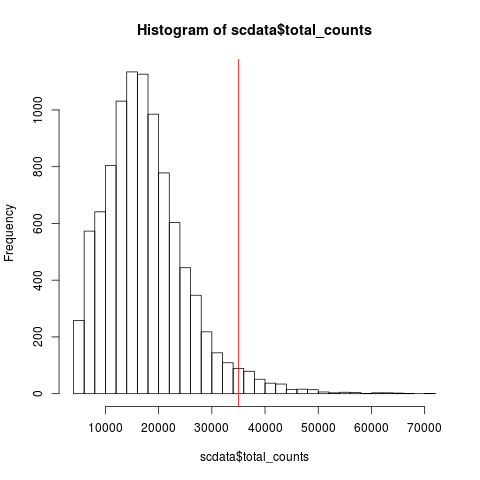

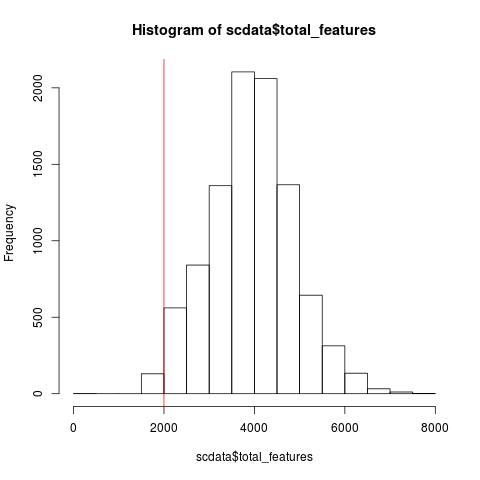

In [3]:
%%R

library(SingleCellExperiment)
library(scater)
library(scran)
options(stringsAsFactors = FALSE)
gc()
###########################BEGIN CELL FILTERING###################
keep_feature <- rowSums(counts(scdata) > 0) > 0
scdata <- scdata[keep_feature, ]
####### do calculations
logcounts(scdata) <- log2(calculateCPM(scdata, use.size.factors = FALSE) + 1)
tpm(scdata) <- calculateTPM(scdata, effective_length = 5e4)
cpm(scdata) <- calculateCPM(scdata, use.size.factors = FALSE)
####metrics
scdata <- calculateQCMetrics(scdata)

##filter total counts
cutoff_reads = 35000
##plot total counts
hist(
    scdata$total_counts,
    breaks = 25
)
abline(v = cutoff_reads, col = "red")
###cutoff by total counts
filter_by_total_counts <- (scdata$total_counts < cutoff_reads)
print(table(filter_by_total_counts))
##filter total features
cutoff_features = 2000
##plot total features (genes)
hist(
    scdata$total_features,
    breaks = 25
)
abline(v = cutoff_features, col = "red")
###cutoff by total features
filter_by_expr_features <- (scdata$total_features > cutoff_features)
print(table(filter_by_expr_features))
#######filter by total counts, total features
### sufficient features (genes)
### sufficient molecules counted
scdata$use <- (filter_by_expr_features & filter_by_total_counts)
print('number remaining:')
print(sum(scdata$use,na.rm=TRUE))
###########################END CELL FILTERING###################
###########################BEGIN CELL CYLCE FILTERING###################
hg.pairs <- readRDS(system.file("exdata", "human_cycle_markers.rds", package="scran"))
assigned <- cyclone(scdata, pairs=hg.pairs)
colData(scdata)$phase <- assigned$phases


In [4]:
%%R

###########################BEGIN GENE FILTERING###################
###filter number of cells each gene has to be at minimum present in
cutoff_numcells = 3
###filter genes whose absolute counts are at least > 1 and present in at least (cutoff_numcell) # of cells
filter_genes <- apply(
    counts(scdata[ , colData(scdata)$use]), 
    1, 
    function(x) length(x[x > 1]) >= cutoff_numcells
)
rowData(scdata)$use <- filter_genes
print(table(filter_genes))
###save data
dim(scdata[rowData(scdata)$use, colData(scdata)$use])
saveRDS(scdata, file = "scater/filtered.rds")

filter_genes
FALSE  TRUE 
 9695 13311 


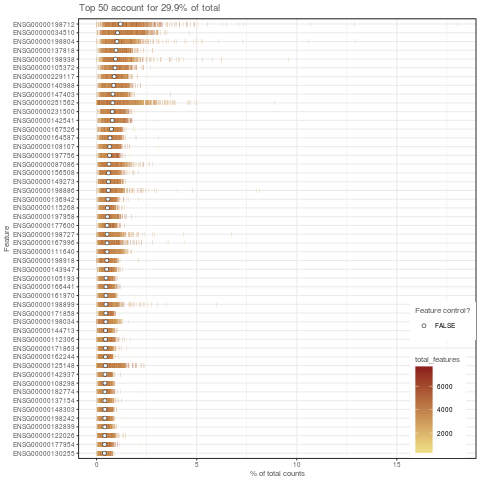

In [5]:
%%R

##############plot genes with highest counts

###plot
plotQC(scdata, type = "highest-expression")

# Section 2, basic visualization of technical bias and QC

In [6]:
%%R
######################################################################
library(SingleCellExperiment)
library(scater)
library(scran)
options(stringsAsFactors = FALSE)
gc()
###readin
scdata <- readRDS("scater/filtered.rds")
###subset by is_matched
test <- scdata[ , colData(scdata)$is_matched=='Y']
###subset by qc'd 
scdata.qc <- test[rowData(test)$use, colData(test)$use]
###save
saveRDS(scdata.qc, file = "scater/scdata_qc.rds")

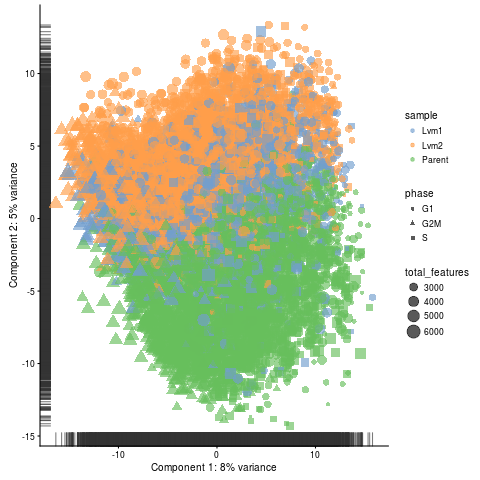

In [7]:
%%R
#############see all features
###plot PCA

plotPCA(
    scdata.qc,
    exprs_values = "logcounts",
    colour_by = "sample",
    size_by = "total_features",
    shape_by = "phase",
    draw_plot=TRUE,
    return_SCE=FALSE,
    ncomponents = 2
)


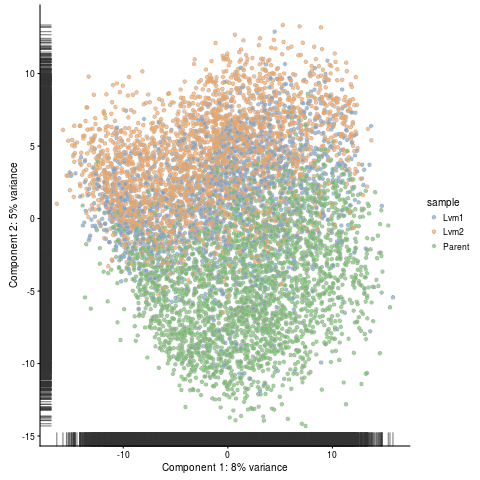

In [8]:
%%R
#############see only sample feature
###plot PCA

plotPCA(
    scdata.qc,
    exprs_values = "logcounts",
    colour_by = "sample",
    draw_plot=TRUE,
    return_SCE=FALSE,
    ncomponents = 2
)


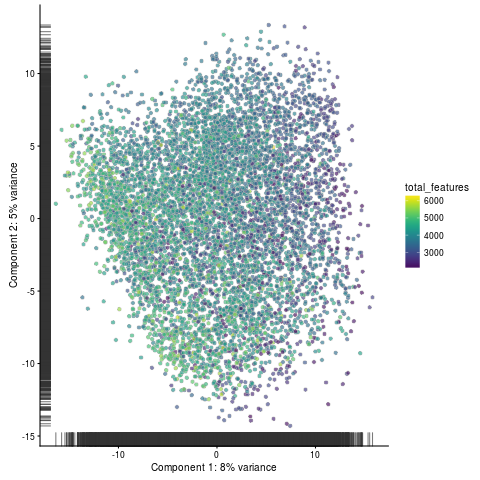

In [9]:
%%R
####################################################################
####################################################################
###plot PCA

plotPCA(
    scdata.qc,
    exprs_values = "logcounts",
    colour_by = "total_features",
    draw_plot=TRUE,
    return_SCE=FALSE,
    ncomponents = 2
)


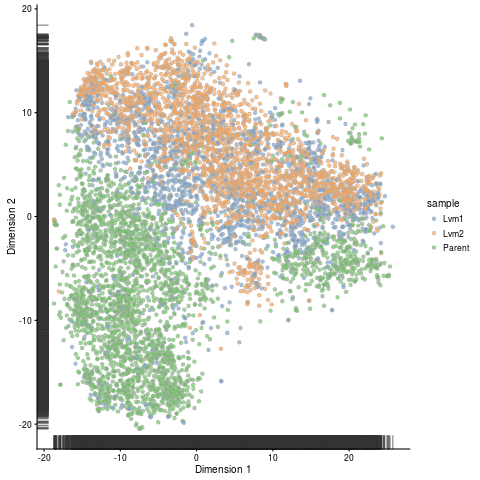

In [10]:
%%R

###plot TSNE

plotTSNE(
    scdata.qc,
    perplexity = 30,
    rand_seed = 123456,
    exprs_values = "logcounts",
    colour_by = "sample",
    draw_plot=TRUE,
    return_SCE=FALSE
)


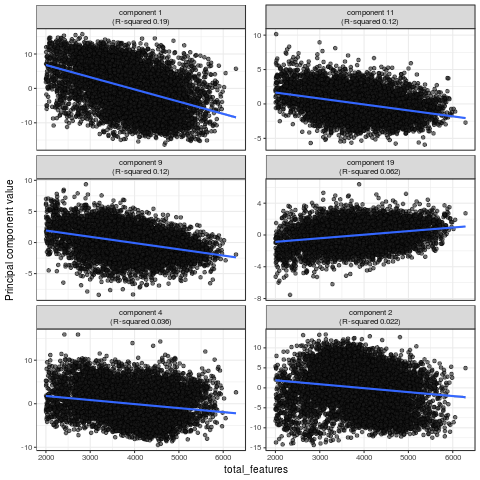

In [11]:
%%R

###find covariate correlation with PC using default method (logcounts(cpm))

plotQC(
    scdata.qc,
    type = "find-pcs",
    exprs_values = "logcounts",
    variable = "total_features"
)


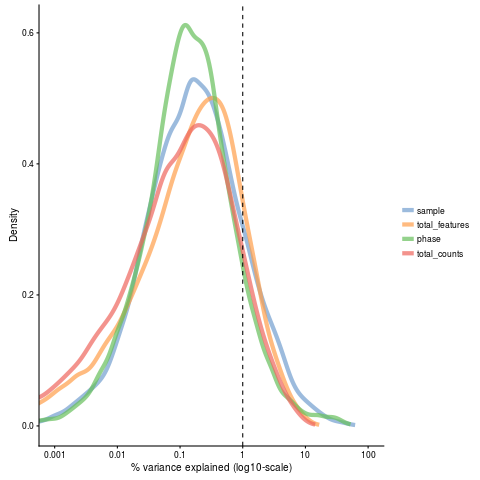

In [12]:
%%R

###find explanatory variables

plotQC(
    scdata.qc,
    type = "expl",
    exprs_values = "logcounts",
    variables = c(
        "total_features",
        "total_counts",
        "sample",
        "phase"
    )
)


In [2]:
%%R
###
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
###readin
scdata.qc <- readRDS("scater/scdata_qc.rds")
###
# logcounts(scdata.qc) <- log2(as.matrix(counts(scdata.qc)) + 1)
###save file
saveRDS(scdata.qc, file = "scater/ready_for_clustering.rds")

/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: SummarizedExperiment

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: GenomicRanges

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching pack

# Section 3, biological analysis

# Cluster together - P, LVM1, LVM2

cluster with SC3 v = 1.7.7

In [3]:
%%R

###
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/ready_for_clustering.rds")
###
rowData(scdata)$feature_symbol <-rownames(scdata)
####cluster
scdata <- sc3(scdata, ks = 2:25, biology = TRUE,n_cores=16)

/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Setting SC3 parameters...

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Your dataset contains more than 2000 cells. Adjusting the nstart parameter of kmeans to 50 for faster performance...

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Defining training cells for SVM using 5000 random cells...

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Calculating distances between the cells...

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Performing transformations and calculating eigenvectors...

  warnings.warn(x, RRuntimeWarning)
/home/

In [4]:
%%R
####because they are using sampling on cells = 5000, we have to use SVM to recluster based on training set of 5000
scdata <- sc3_run_svm(scdata, ks = 2:25)
col_data <- colData(scdata)
head(col_data[ , grep("sc3_", colnames(col_data))])
###save file
saveRDS(scdata, file = "scater/sc3_clustered.rds")

In [5]:
%%R
####recalculate biology
metadata(scdata)$sc3$svm_train_inds <- NULL
scdata <- sc3_calc_biology(scdata, ks = 2:25)
###save file
saveRDS(scdata, file = "scater/sc3_clustered.rds")

## Determine Clusters

[1] "k = 2-25"


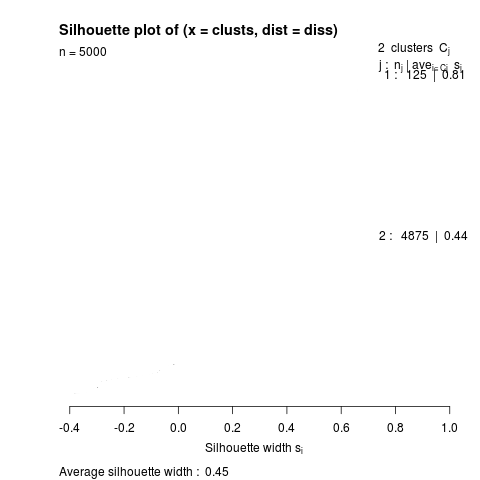

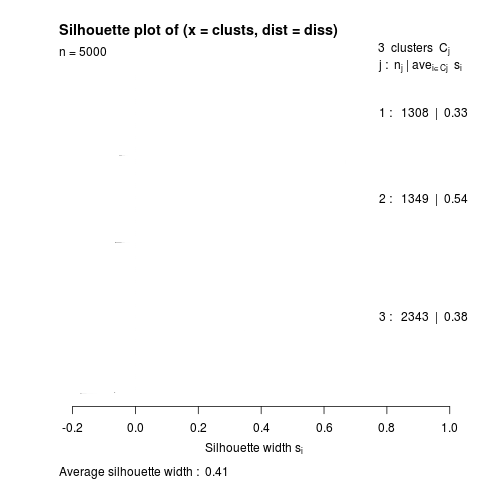

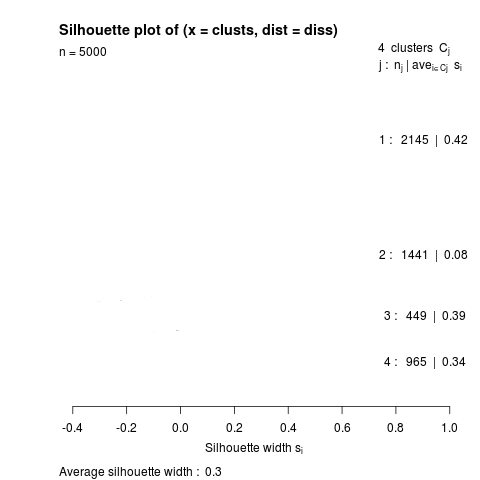

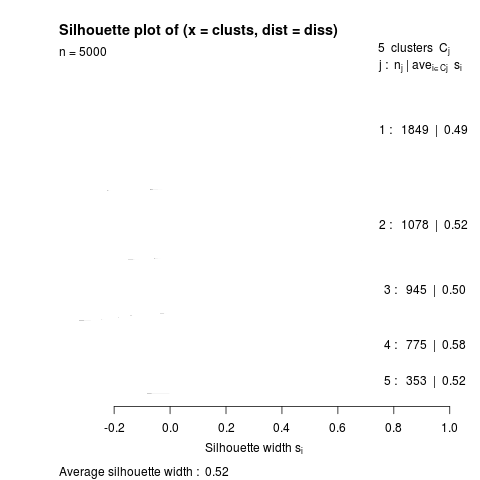

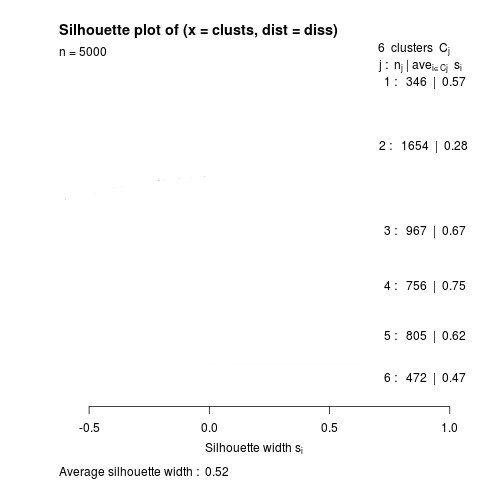

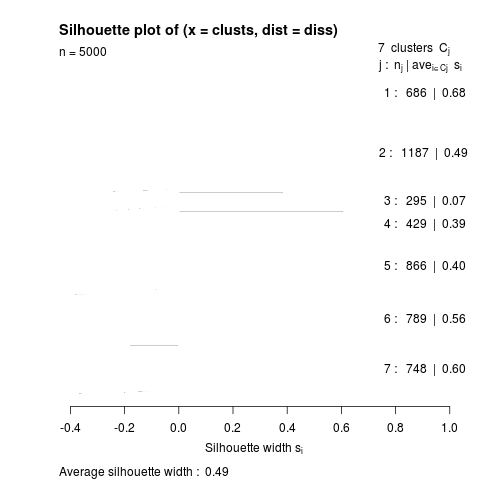

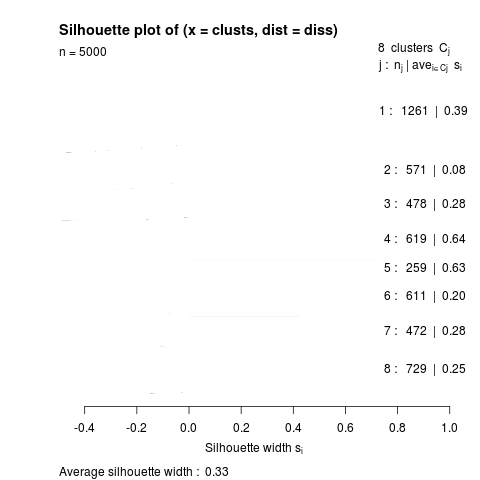

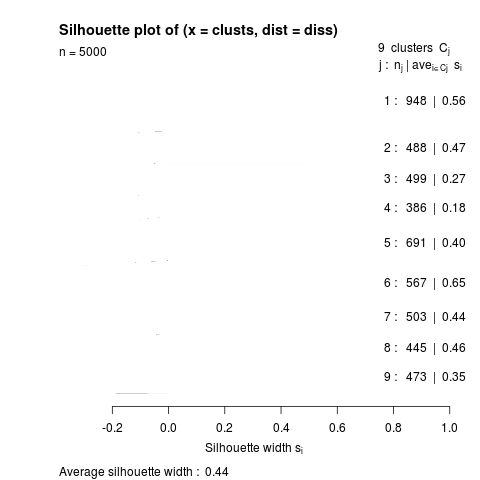

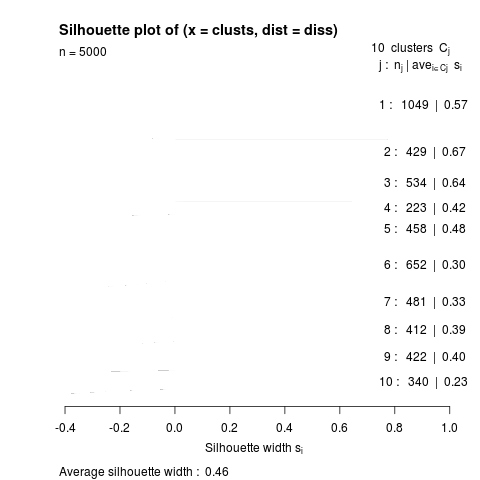

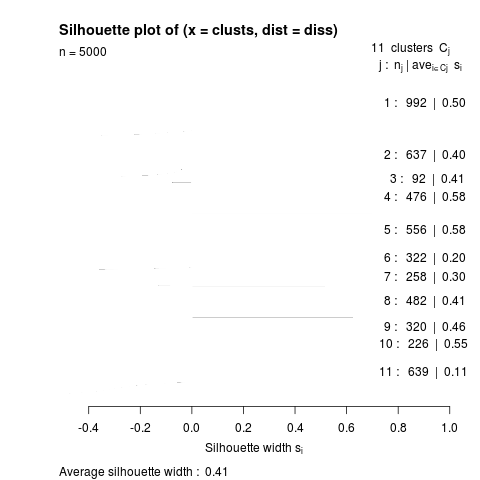

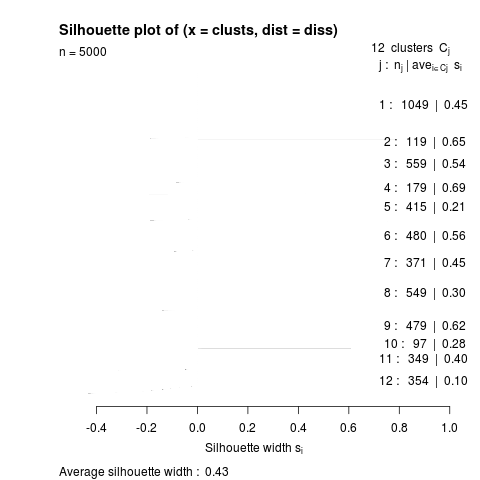

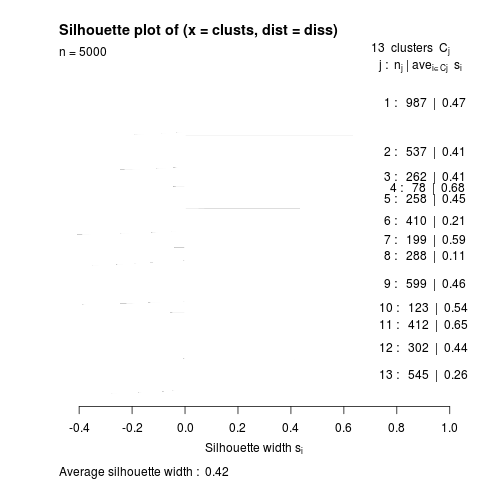

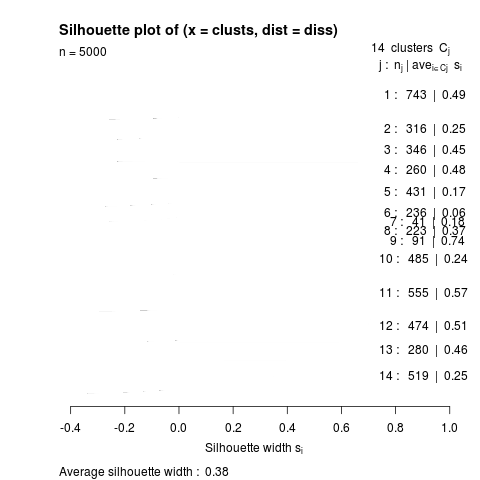

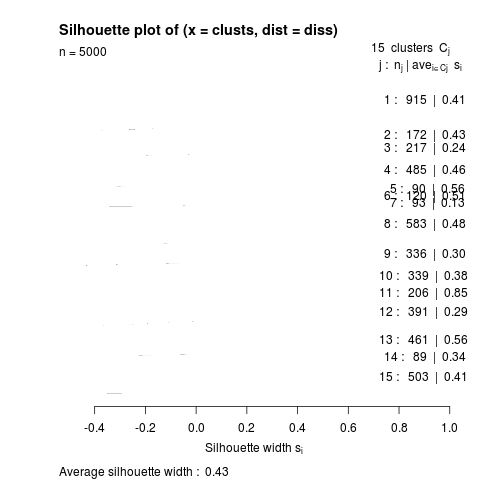

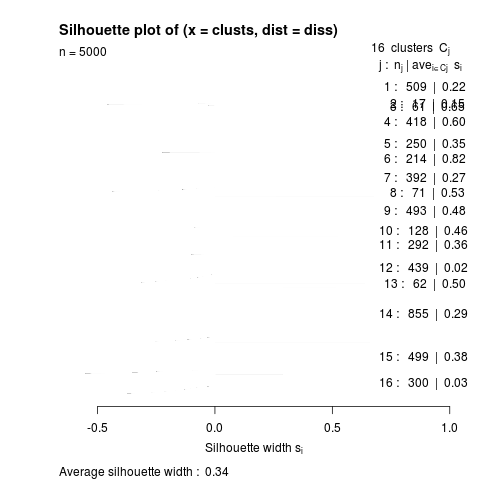

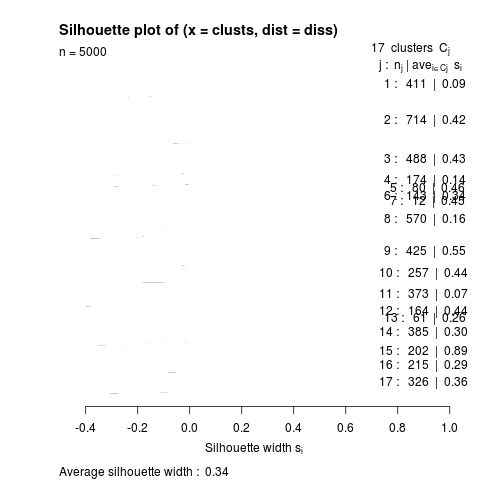

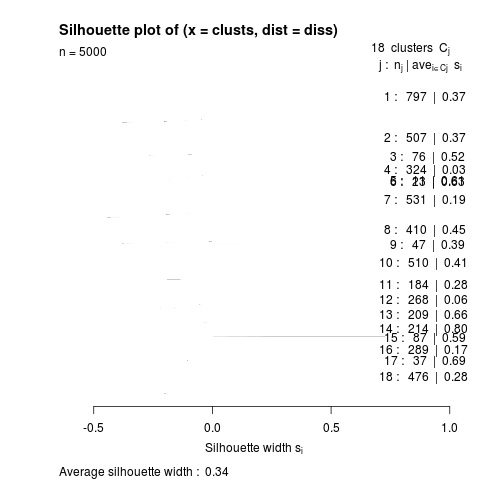

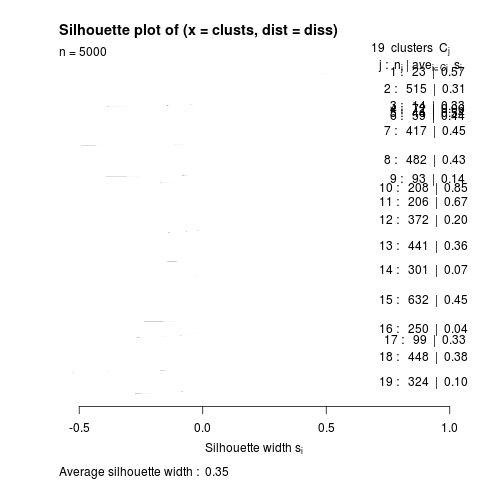

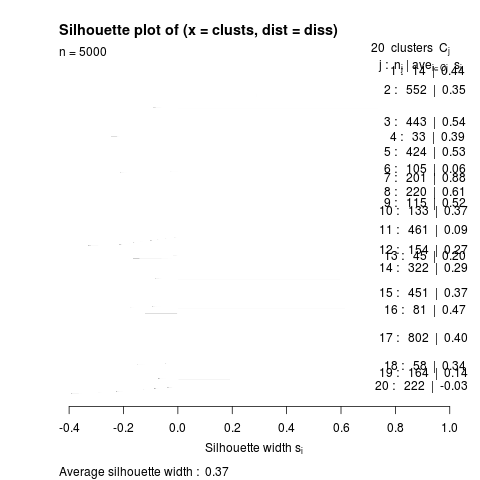

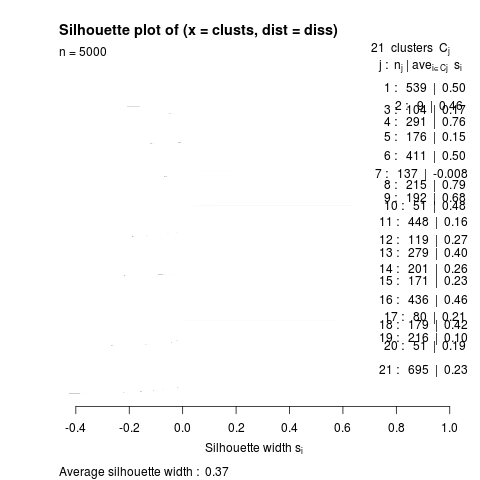

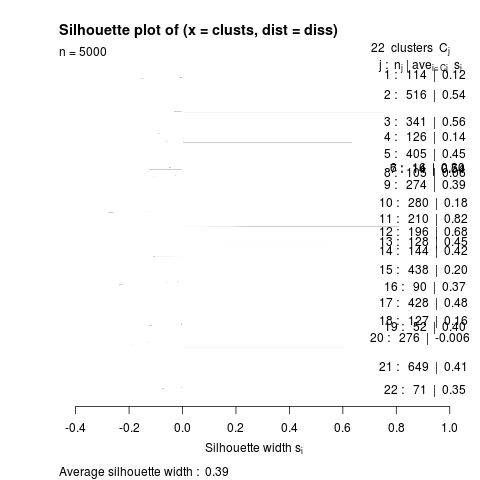

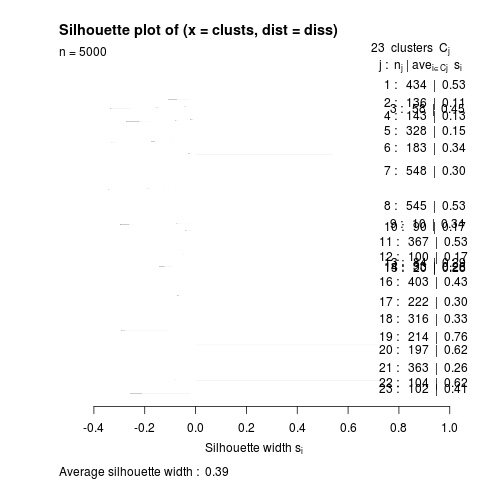

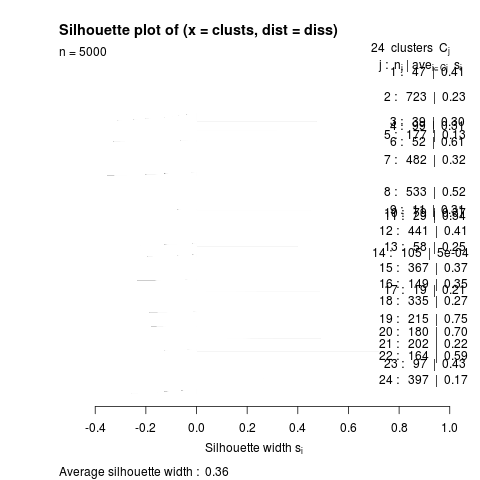

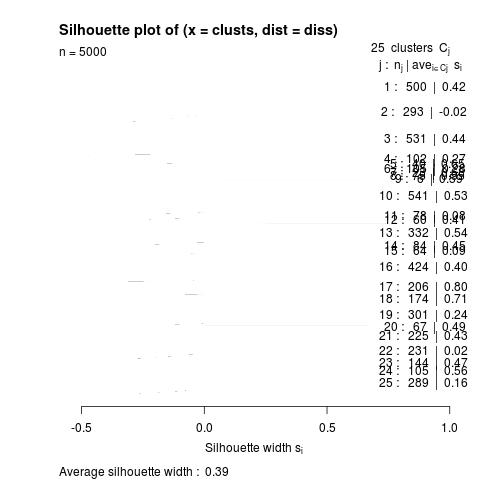

In [6]:
%%R

print("k = 2-25")
for (i in 2:25){
    sc3_plot_silhouette(scdata,k=i)
}


# Visualize

In [37]:
%%R

###
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/sc3_clustered.rds")
###format
colData(scdata)$sc3_5_clusters <- as.factor(colData(scdata)$sc3_5_clusters)

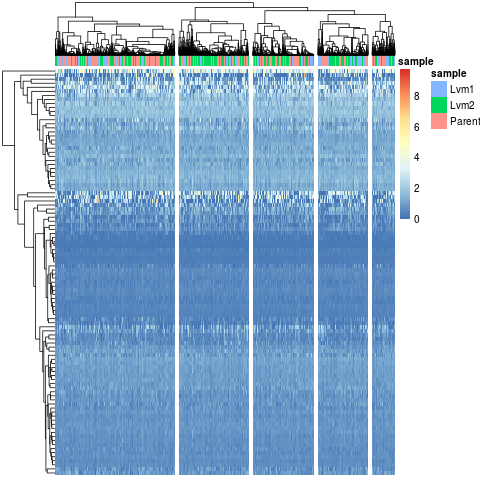

In [45]:
%%R

#####see clustering tree and representation by sample type
sc3_plot_expression(scdata, k = 5, show_pdata = "sample")

In [ ]:
%%R

scdata

In [46]:
%%R

perplex = 30
###run TSNE
scdata <- runTSNE(scdata,exprs_values='logcounts',perplexity = perplex,rand_seed = 50000)

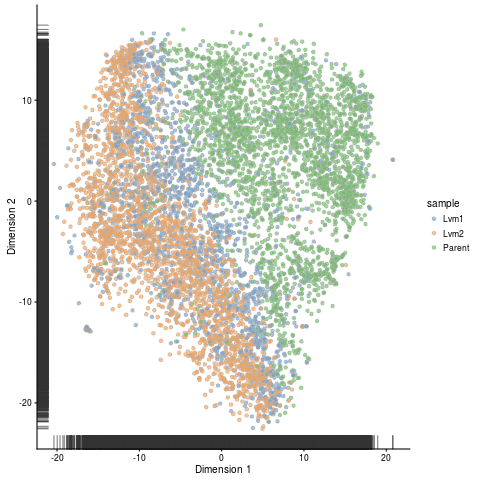

In [47]:
%%R

###plot TSNE
plotTSNE(
    scdata,
    colour_by = "sample"
)


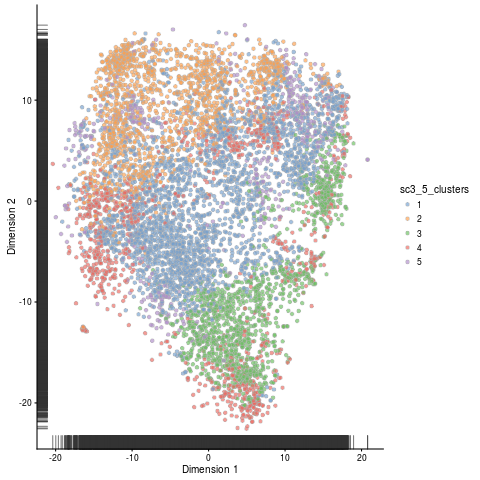

In [48]:
%%R

###plot TSNE

plotTSNE(
    scdata,
    colour_by = "sc3_5_clusters"
)

In [49]:
%%R

###save file
saveRDS(scdata, file = "scater/sc3_clustered.rds")

# Get markers from SC3 for each cluster 

In [ ]:
%%R

###
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/sc3_clustered.rds")


In [ ]:
%%R
#####write all results
sc3_export_results_xls(scdata, filename = "scater/sc3_exported_results.xls")

In [ ]:
%%R
#####write gene names, for manual excel analysis
write.table(data.frame(rowData(scdata)$feature_symbol), file="scater/genes.tsv", sep='\t')    

# Feature Selection for heatmap

In [ ]:
%%R

####clean data for M3Drop
library(scRNA.seq.funcs)
library(matrixStats)
library(M3Drop)
library(RColorBrewer)
set.seed(1)


scdata <- readRDS("scater/sc3_clustered.rds")
cellLabels <- colData(scdata)$sc3_10_clusters

scdata_list <- M3DropCleanData(
    counts(scdata),
    labels = cellLabels,
    is.counts = TRUE
)

####data formatting
expr_matrix <- scdata_list$data # Normalized & filtered expression matrix
celltype_labs <- factor(scdata_list$labels) # filtered cell-type labels
cell_colors <- brewer.pal(max(10,length(unique(celltype_labs))), "Set3")

print(dim(counts(scdata)))
print(dim(expr_matrix))

In [ ]:
%%R

####find DE features using highly variable gene model (Brennecke)
Brennecke_HVG <- BrenneckeGetVariableGenes(
    expr_matrix,
    fdr = 0.01,
    minBiolDisp = 0.5
)

####plot HVG results
M3DropExpressionHeatmap(
    Brennecke_HVG,
    expr_matrix,
    cell_labels = celltype_labs
)


In [ ]:
%%R
####fitted to MM plot, different method
M3Drop_genes <- M3DropDifferentialExpression(
    expr_matrix,
    mt_method = "fdr",
    mt_threshold = 0.01
)

####plot HVG results
M3DropExpressionHeatmap(
    M3Drop_genes,
    expr_matrix,
    cell_labels = celltype_labs
)



In [ ]:
%%R

##########################overlay with SC3 clusters

####clean data for M3Drop
library(scRNA.seq.funcs)
library(matrixStats)
library(M3Drop)
library(RColorBrewer)
set.seed(1)


scdata <- readRDS("scater/sc3_clustered.rds")
cellLabels <- colData(scdata)$sc3_10_clusters

scdata_list <- M3DropCleanData(
    counts(scdata),
    labels = cellLabels,
    is.counts = TRUE
)

####data formatting
expr_matrix <- scdata_list$data # Normalized & filtered expression matrix
celltype_labs <- factor(scdata_list$labels) # filtered cell-type labels
cell_colors <- brewer.pal(max(3,length(unique(celltype_labs))), "Set3")

print(dim(counts(scdata)))
print(dim(expr_matrix))

####find DE features using highly variable gene model (Brennecke)
Brennecke_HVG <- BrenneckeGetVariableGenes(
    expr_matrix,
    fdr = 0.02,
    minBiolDisp = 0.5
)

####plot HVG results
M3DropExpressionHeatmap(
    Brennecke_HVG,
    expr_matrix,
    cell_labels = celltype_labs
)


In [ ]:
%%R

print(length(Brennecke_HVG))
print(dim(M3Drop_genes))

In [ ]:
%%R
mydata = Brennecke_HVG
write.table(mydata, "scater/filtered_HVG.txt", sep="\t") 
mydata = M3Drop_genes
write.table(mydata, "scater/filtered_M3Drop_genes.txt", sep="\t") 


# Cluster separately - P, LVM1, LVM2

# THIS FILE MOVED OVER TO PIPELINE 2 FOR VISUALIZATION
### "scater/separately_clustered/sc3_clustered_P.rds" 
### "scater/separately_clustered/sc3_clustered_LVM1.rds"
### "scater/separately_clustered/sc3_clustered_LVM2.rds"

In [41]:
%%R

###
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/ready_for_clustering.rds")
#####subset in preparation for separate clustering
P <- scdata[ , colData(scdata)$sample == "Parent"]
LVM1 <- scdata[ , colData(scdata)$sample == "Lvm1"]
LVM2 <- scdata[ , colData(scdata)$sample == "Lvm2"]
#####run TSNE separately
P <- runTSNE(P,exprs_values='logcounts',perplexity = 30,rand_seed = 10000)
LVM1 <- runTSNE(LVM1,exprs_values='logcounts',perplexity = 30,rand_seed = 10000)
LVM2 <- runTSNE(LVM2,exprs_values='logcounts',perplexity = 30,rand_seed = 10000)

#####note, the code below is just factored for each dataset (P, LVM1, LVM2)

##############
########cluster P
##############
scdata <- P
#####
rowData(scdata)$feature_symbol <-rownames(scdata)
####cluster
scdata <- sc3(scdata, ks = 2:10, biology = TRUE,n_cores=16)
####estimate optimal cluster size
scdata <- sc3_estimate_k(scdata)
print(metadata(scdata)$sc3$k_estimation)
###save file
saveRDS(scdata, file = "scater/separately_clustered/sc3_clustered_P.rds")

##############
########cluster LVM1
##############
scdata <- LVM1
#####
rowData(scdata)$feature_symbol <-rownames(scdata)
####cluster
scdata <- sc3(scdata, ks = 2:10, biology = TRUE,n_cores=16)
####estimate optimal cluster size
scdata <- sc3_estimate_k(scdata)
print(metadata(scdata)$sc3$k_estimation)
###save file
saveRDS(scdata, file = "scater/separately_clustered/sc3_clustered_LVM1.rds")

##############
########cluster LVM2
##############
scdata <- LVM2
#####
rowData(scdata)$feature_symbol <-rownames(scdata)
####cluster
scdata <- sc3(scdata, ks = 2:10, biology = TRUE,n_cores=16)
####estimate optimal cluster size
scdata <- sc3_estimate_k(scdata)
print(metadata(scdata)$sc3$k_estimation)
###save file
saveRDS(scdata, file = "scater/separately_clustered/sc3_clustered_LVM2.rds")

/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Setting SC3 parameters...

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Your dataset contains more than 2000 cells. Adjusting the nstart parameter of kmeans to 50 for faster performance...

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Calculating distances between the cells...

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Performing transformations and calculating eigenvectors...

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Performing k-means clustering...

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/pytho


[1] 21

[1] 17

[1] 19


# Process in python

In [ ]:
%%R

write.csv(head(assays(scdata.qc,"combat")),'combat.tsv',sep='\t')


In [ ]:
%%R

normcounts(scdata.qc) <- assays(scdata.qc,"combat")

write.csv(head(normcounts(scdata.qc)),'after.tsv',sep='\t')

In [ ]:
def print_cluster4_genevals(gene,cluster4_index):
####
    cluster4 = []
    for num in cluster4_index:
        name = 'cell_'+num
        cluster4.append(expr[name].loc[gene])
    ####
    print('cluster4',np.average(cluster4))
    print(len(cluster4))
    ####
    cluster_total = list(expr.columns)
    cluster_not = list(cluster_total)
    # print(cluster_total)
    for cell in cluster_total:
    #     print("dddddd",cell)
        for num in cluster4_index:
            name = 'cell_'+num
    #         print(name)
            if cell == name:
                cluster_not.remove(cell)
    #             print('removed',cell)
    # print(cluster_not)
    ####
    cluster4_not = []
    for cell in cluster_not:
        cluster4_not.append(expr[cell].loc[gene])
    ####
    print('cluster4_not',np.average(cluster4_not))
    print(len(cluster4_not))
    ############ttest
    results = stats.ttest_ind(cluster4,cluster4_not,nan_policy='omit')
    print(results)

In [ ]:
#####look at gene EGFR
os.system('mkdir sufam')
###
def cmd_extract_reads(loc, filename):
    folder = filename[24:26]
    cmd = 'samtools view -bh ../B_G_'+folder+'/'+filename+' '+loc+' > EGFR.'+filename
    return(os.system(cmd))
def cmd_index(filename):
    cmd = 'samtools index '+filename
    return(os.system(cmd))
def cmd_tofasta(filename):
    cmd = 'samtools fasta '+filename+' > '+filename+'.fa'
    return(os.system(cmd))
def cmd_sufam(filename):
    cmd = 'sufam /avicenna/genomes/hg38_2/hg38.fa mutations.vcf '+filename+' 2> sufam/'+filename+'.log > sufam/'+filename+'.tsv'
    return(os.system(cmd))
expr = pd.read_csv("scater/filtered_exprs_edited.txt", sep=',',index_col = 0)
####
cluster3_index = ['4','5','9','10','38']
gene = 'ENSG00000146648'
####
print_cluster3_genevals(gene,cluster3_index)

####pull out EGFR exon 21 reads from bam files
loc = "chr7:55191822"
###
files = pd.read_csv("scater/filtered_file.txt", sep= '\t', index_col = 0)
files = list(files['x'])
###
# for name in files:
#     cmd_extract_reads(loc,name)
#     cmd_index('EGFR.'+name)
#     cmd_tofasta('EGFR.'+name)
#     cmd_sufam('EGFR.'+name)

In [ ]:
####process mutation data
df_files = pd.DataFrame(files)
df_files.index = files
###
files_sufam = []
for name in files:
    files_sufam.append('sufam/EGFR.'+name+'.tsv')
df_files['sufam'] = files_sufam
###
df_files.drop(0,axis=1,inplace=True)
###
sufam_out = pd.read_csv(df_files['sufam'][18],sep='\t',index_col = 0)
for i in range(len(df_files['sufam'])):
    if i != 0:
        temp = pd.read_csv(df_files['sufam'][i],sep='\t',index_col = 0)
        sufam_out = sufam_out.append(temp)
sufam_out

table_cell = pd.read_csv('scater/filtered_file_edited.csv',sep=',',index_col=0)
mutation = sufam_out.merge(table_cell,left_index=True,right_index=True)
mutation.to_csv('sufam/mutations.out',sep='\t')
mutation = mutation[mutation['cov']>1][['cell','cov','val_maf']]
mutation.to_csv('sufam/mutations.filtered.out',sep='\t')

In [ ]:
# #####compare alignment
# from Bio import SeqIO
# from Bio import pairwise2
# ####refseq is normal
# ref_seq = "TTTTGGGCTGGCCAA"
# ####format seqs for comparison
# files_fa = []
# for name in files:
#     files_fa.append('EGFR.'+name+'.fa')
# ###
# seqs = []
# for record in SeqIO.parse(files_fa[0], "fasta"):
#     seqs.append(record.seq)
# ####
# for seq in seqs:
#     print pairwise2.align.globalxx(ref_seq, seq)

In [ ]:
#####look at gene myc
expr = pd.read_csv("scater/filtered_exprs_edited.txt", sep=',',index_col = 0)
####
cluster3_index = ['4','5','9','10','38']
gene = 'ENSG00000136997'
####
print_cluster3_genevals(gene,cluster3_index)

In [ ]:
#####look at gene tp53
expr = pd.read_csv("scater/filtered_exprs_edited.txt", sep=',',index_col = 0)
####
cluster3_index = ['4','5','9','10','38']
gene = 'ENSG00000141510'
####
print_cluster3_genevals(gene,cluster3_index)

In [ ]:
#####look at gene stat3
expr = pd.read_csv("scater/filtered_exprs_edited.txt", sep=',',index_col = 0)
####
cluster3_index = ['4','5','9','10','38']
gene = 'ENSG00000168610'
####
print_cluster3_genevals(gene,cluster3_index)

In [ ]:
#####look at gene ccnd1
expr = pd.read_csv("scater/filtered_exprs_edited.txt", sep=',',index_col = 0)
####
cluster3_index = ['4','5','9','10','38']
gene = 'ENSG00000110092'
####
print_cluster3_genevals(gene,cluster3_index)

In [ ]:
####this is the egfr expression across cells
expr = pd.read_csv("scater/filtered_exprs.txt", sep='\t',index_col = 0)
# expr.loc['ENSG00000146648']

In [ ]:
####matching HVG list
HVG = pd.read_csv("scater/filtered_HVG.txt", sep='\t',index_col = 1)
HVG.columns = [['rank']]
###
ENS = pd.read_csv("ensmbl_proteincoding.txt", sep='\t',index_col = 0)
HVG = HVG.merge(ENS,left_index = True, right_index = True)
HVG.columns = [['rank','name']]
###save
HVG.to_csv('scater/filtered_matched_HVG.txt', sep='\t')

# Analyze using SCDE

In [ ]:
%%R

library(scRNA.seq.funcs)
library(matrixStats)
library(M3Drop)
library(RColorBrewer)
library(scde)
set.seed(1)

####readin data
scdata <- readRDS("scater/filtered_3_sc3.rds")

scdata

In [ ]:
%%R

#####format
test <- apply(
    counts(scdata),
    2,
    function(x) {
        storage.mode(x) <- 'integer'
        return(x)
    }
)

x <- colData(scdata)$sc3_4_clusters

l2cols <- c("coral4", "olivedrab3", "skyblue2", "cornsilk")[as.integer(factor(x, levels = c("1", "2", "3","4")))]

###run error modelling

knn <- knn.error.models(test, k = ncol(test)/4, n.cores = 4, min.count.threshold = 2, min.nonfailed = 5, max.model.plots = 10)

varinfo <- pagoda.varnorm(knn, counts = test, trim = 2/ncol(test), max.adj.var = 5, n.cores = 4, plot = TRUE)

varinfo <- pagoda.subtract.aspect(varinfo, colSums(test[, rownames(knn)]>0))

####run gene sets analysis

library(org.Hs.eg.db)

ids <- unlist(lapply(mget(rownames(test), org.Hs.egENSEMBL2EG, ifnotfound = NA), function(x) x[1]))
rids <- names(ids); names(rids) <- ids 
gos.interest <- unique(c(ls(org.Hs.egGO2ALLEGS))) 
go.env <- lapply(mget(gos.interest, org.Hs.egGO2ALLEGS), function(x) as.character(na.omit(rids[x]))) 
go.env <- clean.gos(go.env) # remove GOs with too few or too many genes
go.env <- list2env(go.env) # convert to an environment

#### pagoda

pwpca <- pagoda.pathway.wPCA(varinfo, go.env, n.components = 1, n.cores = 4)

png(filename = "1.png")
df <- pagoda.top.aspects(pwpca, return.table = TRUE, plot = TRUE, z.score = 1.96)
dev.off()

head(df)

write.table(df, file = "scde/gsea_GO.txt", row.names = TRUE, col.names = TRUE, sep = "\t", quote = FALSE)

png(filename = "2.png")
clpca <- pagoda.gene.clusters(varinfo, trim = 7.1/ncol(varinfo$mat), n.clusters = 50, n.cores = 4, plot = TRUE)
dev.off()

png(filename = "3.png")
df <- pagoda.top.aspects(pwpca, clpca, return.table = TRUE, plot = TRUE, z.score = 1.96)
dev.off()

write.table(df, file = "scde/gsea_deNovo.txt", row.names = TRUE, col.names = TRUE, sep = "\t", quote = FALSE)

######visualize

tam <- pagoda.top.aspects(pwpca, clpca, n.cells = NULL, z.score = qnorm(0.01/2, lower.tail = FALSE))

hc <- pagoda.cluster.cells(tam, varinfo)

tamr <- pagoda.reduce.loading.redundancy(tam, pwpca, clpca)

png(filename = "4.png")
tamr2 <- pagoda.reduce.redundancy(tamr, distance.threshold = 0.9, plot = TRUE, cell.clustering = hc, labRow = NA, labCol = NA, box = TRUE, margins = c(0.5, 0.5), trim = 0)
col.cols <- rbind(groups = cutree(hc, 4))
pagoda.view.aspects(tamr2, cell.clustering = hc, box = TRUE, labCol = NA, margins = c(0.5, 20), col.cols = rbind(l2cols))
dev.off()

png(filename = "5.png")
pagoda.view.aspects(tamr2, cell.clustering = hc, row.clustering = NA, box = TRUE, labCol = NA, margins = c(0.5, 20), col.cols = rbind(l2cols))
dev.off()

In [ ]:
%%R

save(file="121417.RData")

In [ ]:
%%R

##pull out individual genes

pagoda.show.pathways(c("GO:0000982"), varinfo, go.env, cell.clustering = hc, margins = c(1,5), show.cell.dendrogram = TRUE, showRowLabels = TRUE, showPC = TRUE)


In [ ]:
%%R

##pull out individual genes
test.pattern <- pagoda.show.pathways(c("GO:0052695"), varinfo, go.env, show.cell.dendrogram = TRUE, cell.clustering = hc, showRowLabels = TRUE)

varinfo.test <- pagoda.subtract.aspect(varinfo, test.pattern)

In [ ]:
%%R

table(clpca$clusters$geneCluster.22)


In [ ]:
pagoda.view.aspects(tamr2, cell.clustering = hc, row.clustering = NA, box = TRUE, labCol = NA, margins = c(0.5, 20), col.cols = rbind(l2cols))


